# Сравнение классификаторов

Суть задания состоит в том, чтобы сравнить различные классификаторы на наборе данных Extended MNIST https://www.nist.gov/itl/products-and-services/emnist-dataset. <br>
Набор одержит монохромные изображения латинских букв. <br>
На каждом изображении содержится по одной букве в низком разрешении (28 на 28 пикселей). <br>
<br>
Нужно использовать 88,800 изображений для обучения и 14,800 изображений, чтобы проверить качество классификации. <br>
При тестировании следует применить различные модели, включая (но не ограничиваясь): <br>
-- KNeighborsClassifier <br>
-- LogisticRegression <br>
-- Naive Bayes <br>
-- Bayesian Classifier <br>
-- Linear SVC <br>
-- DecisionTreeClassifier <br>
<br>
В этой части требуется провести эксперименты с различными моделями и гиперпараметрами моделей. <br>
Оценить качество классификаторов и сравнить их друг с другом по различным метрикам (не только по основной метрике соревнования).<br>
<br>
Попробуйте уменьшить размерность пространства при помощи PCA (или других аналогичных) методов и сравнить результаты до и после уменьшения размерности.<br>

## Подготовка данных

### Чтение файлов csv

In [1]:
# Распаковка zip с датасетами (для работы с github, файлы больше 100мб требуют git lfs, но он почему-то не захотел работать)
import shutil
shutil.unpack_archive("emnist-letters.zip")

In [2]:
# Функция для преобразования csv в numpy
import pandas as pd
import numpy as np

def loadCsv(path):
    # Load train data
    X = pd.read_csv(path, header=None)

    # separate column w/ predicts
    y = pd.DataFrame(X[0])
    y.columns=['Y']
    y = y.to_numpy().T[0]

    X = X.drop(columns={0})
    X = X.to_numpy()
    return [X, y]

In [3]:
# Load exam data
X_exam = pd.read_csv('emnist-letters-exam.csv', index_col=0)
X_exam = X_exam.to_numpy()

# Load train & test data
X_train, y_train = loadCsv('emnist-letters-train.csv')
X_test, y_test = loadCsv('emnist-letters-test.csv')

### Выводим изображения букв

In [4]:
import matplotlib.pyplot as plt

In [5]:
# Функция для вывода буквы на ось из линейного массива
def printLetter(ax, pic28x28, title = ""):
    pic28x28 = np.array(pic28x28).reshape((28,28))
    ax.imshow(pic28x28, cmap='gist_gray')
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    if len(title) != 0:
        ax.set_title(title)

In [6]:
# Функция для вывода 52 случайных букв из массива Х
def printSomeLetters(X):
    lettersPrintList = [0, 1]
    fig, axes = plt.subplots(4, 13, figsize=(20, 7))
    for yUnique in np.unique(y_train):
        for i in lettersPrintList:
            ax = axes.ravel()[i + len(lettersPrintList) * (yUnique-1)]
            printLetter(ax, X[ np.random.randint( len(X) ) ])

#### Выводим изображения букв и набора для обучения

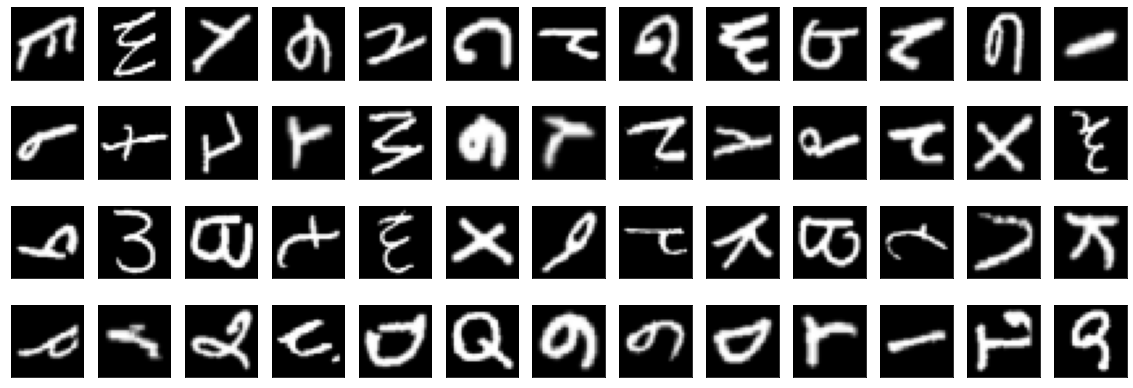

In [7]:
printSomeLetters(X_train)

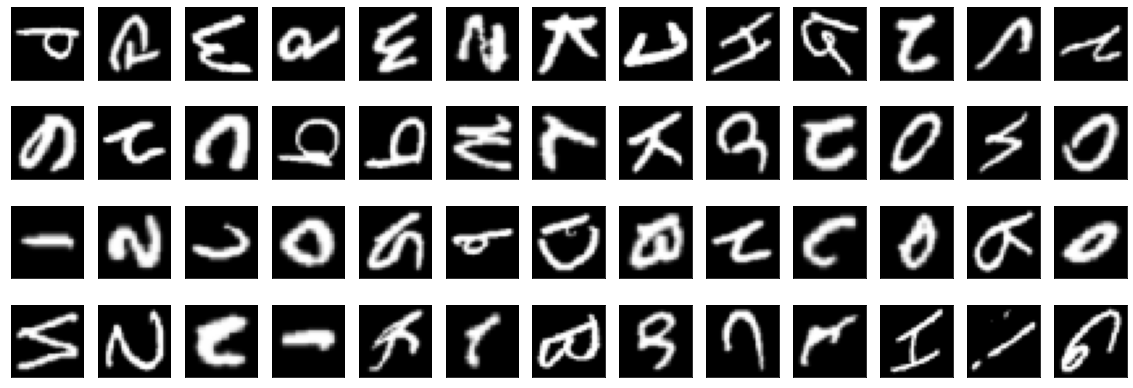

In [8]:
printSomeLetters(X_test)

##### Буквы выглядят повернутыми, транспонируем матрицы изображений

In [9]:
for i, X in enumerate(X_train):
    X_train[i] = np.array(X).reshape((28, 28)).T.ravel()
for i, X in enumerate(X_test):
    X_test[i] = np.array(X).reshape((28, 28)).T.ravel()

##### Повторно выводим буквы из набора для обучения

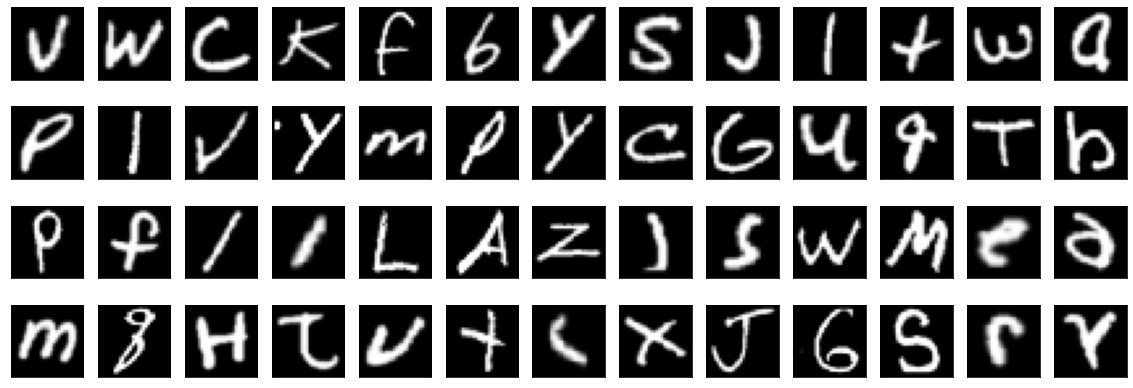

In [10]:
printSomeLetters(X_train)

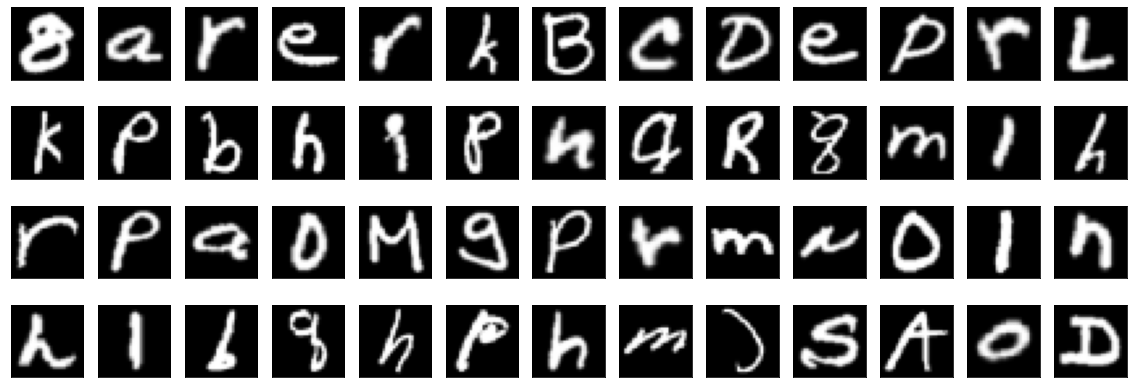

In [11]:
printSomeLetters(X_test)

#### Выводим изображения букв и набора для проверки

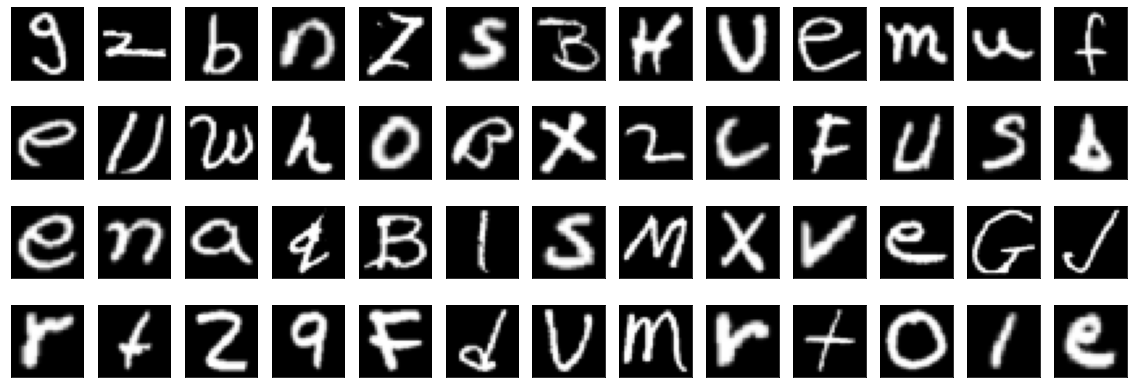

In [12]:
printSomeLetters(X_exam)

### Utility Functions

In [13]:
# Функция для построения непрерывный график по точкам
# ax - ось, для отображения графика
# data - точки, Y  

def plotAlignX(ax, X):
        idxX = np.arange(0,len(X)) # соответсвие каждому Y и его индексу если X пуст
        ax.set_xticks(idxX)
        ax.set_xticklabels(X)
        ax.set_xlim(-1, len(idxX))

def plotAlignY(ax, Y):
        minScale, maxScale = 0.95, 1.05 
        dataMin, dataMax = np.min(Y), np.max(Y)
        ax.set_yticks(np.linspace(dataMin * minScale, dataMax * maxScale, 10))
        ax.set_ylim(dataMin * minScale, dataMax * maxScale)

def PlotScoreGraph(ax, colorName, dataY, dataX, alignX = True, alignY = True):
        dataY = np.array(dataY)        

        ax.plot(
                dataY, 
                marker='o',
                color=colorName
                )


        ax.grid(True)

        if alignX == True:
                plotAlignX(ax, dataX)

        if alignY == True:
                plotAlignY(ax, dataY)

        ax.tick_params(
                axis = 'both', 
                which = 'major',
                direction = 'inout',
                bottom = False,
                top = False,
                left = False,
                right = False
                )

In [14]:
# Функция для получения времени обучения, времени работы, предикта
from timeit import default_timer as dtimer

def GetModelPrediction(classifier, X_train, y_train, X_test):
    start_time = dtimer()
    classifier.fit(X_train, y_train)
    timeToFit = dtimer() - start_time
    
    start_time = dtimer()
    predict = classifier.predict(X_test)
    timeToPredict = dtimer() - start_time

    return [timeToFit, timeToPredict, predict]

In [15]:
# Функция для расчета графика зависимости размера тренировочной выборки на точность
def PlotTrainingCurve(classifierInit, X_trainIn, y_trainIn, X_testIn, y_testIn):
    _TrainingSize = np.linspace(10, len(y_trainIn), 12, dtype=np.int32)
    scoreTest = []
    scoreTrain = []
    for _size in _TrainingSize:
        classifier = classifierInit
        X_trainPart = X_trainIn[:_size]
        y_trainPart = y_trainIn[:_size]
        classifier.fit(X_train, y_train)
        scoreTest.append(classifier.score(X_testIn, y_testIn))
        scoreTrain.append(classifier.score(X_trainPart, y_trainPart))

    fig, ax = plt.subplots(figsize=(6, 7))
    ax.plot(_TrainingSize, scoreTrain, marker='o', color='blue')
    ax.plot(_TrainingSize, scoreTest, marker='o', color='green')
    ax.legend(["Train", "Test"],loc=1)
    ax.set(title="Training Set Size to Score",
            xlabel="Size",
            ylabel="Score")
    ax.set_xticks(_TrainingSize)

In [16]:
# Функция для получения статистических метрик из предсказания
from sklearn import metrics

def calcMetrics(y_predict, y_true):
    return [metrics.accuracy_score(y_true, y_predict),
            metrics.precision_score(y_true, y_predict, average='weighted', zero_division=0),
            metrics.recall_score(y_true, y_predict, average='weighted', zero_division=0),
            metrics.f1_score(y_true, y_predict, average='weighted', zero_division=0)]


In [17]:
# Контейнер для хранения метрик
class MetricsPack:
    def __init__(self):
        self.timeToFit  = []
        self.timeToPredict  = []
        self.accuracy  = []
        self.precision  = []
        self.recall  = []
        self.f1  = []
        self.predictions = []
    def Add(self, timeToFit, timeToPredict, predict, metricVals):
        self.timeToFit.append(timeToFit)
        self.timeToPredict.append(timeToPredict)
        self.predictions.append(predict)
        self.accuracy.append(metricVals[0])
        self.precision.append(metricVals[1])
        self.recall.append(metricVals[2])
        self.f1.append(metricVals[3])
    def GetTimeToFit(self):
        return [self.timeToFit, "Time to Fit"]
    def GetTimeToPredict(self):
        return [self.timeToPredict, "Time to Predict"]
    def GetAccuracy(self):
        return [self.accuracy, "Accuracy Score"]
    def GetPrecision(self):
        return [self.precision, "Precision Score"]
    def GetRecall(self):
        return [self.recall, "Recall Score"]
    def GetF1(self):
        return [self.f1, "F1 Score"]

## Уменьшение размерности. PCA.

In [18]:
from sklearn.decomposition import PCA 

In [19]:
pca = PCA().fit(X_train)

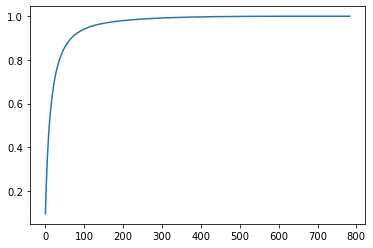

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [21]:
print("Размер, при котором точность увеличивается менее чем на 10**-4: ", 
    sizePCA:=np.where(pca.explained_variance_ratio_ < 10**-4)[0][0])

Размер, при котором точность увеличивается менее чем на 10**-4:  268


In [22]:
pca = PCA(n_components=sizePCA).fit(X_train)

In [23]:
X_exam_pca = pca.transform(X_exam)

In [24]:
X_train_pca = pca.transform(X_train)

In [25]:
X_test_pca = pca.transform(X_test)

## Сравнение моделей

### 
Для каждой модели будут варьироватья гиперпараметры. <br>
Для отслеживания динамики от изменения будут строиться поточечные графики для 6 метрик:<br>
1. Время обучения
2. Время предсказания
3. Accuracy
4. Precision
5. Recall, x_ticks)
6. F1

In [26]:
# Функция для построения графиков метрик
def plotMetric(ax, dataPack, fn, x_ticks):
    ax.set_title(fn(dataPack[0])[1])
    data1 = fn(dataPack[0])[0]
    data2 = fn(dataPack[1])[0]
    PlotScoreGraph(ax, 'red', data1, x_ticks, False, False)
    PlotScoreGraph(ax, 'blue', data2, x_ticks, False, False)

    data = np.array([data1, data2]).ravel()
    plotAlignY(ax, data)

    if len(x_ticks) == 0:
        x_ticks = np.arange(0,len(data1))
    plotAlignX(ax, x_ticks)
    
    ax.legend(["Original", "PCA("+str(sizePCA)+")"])

def plot6Metrics(packOrig:MetricsPack, packPCA:MetricsPack, x_ticks):
    fg, ax = plt.subplots(2, 3, figsize=(18, 7))
    ax = ax.ravel()
    packs = [packOrig, packPCA]
    plotMetric(ax[0], packs, MetricsPack.GetTimeToFit, x_ticks)
    plotMetric(ax[1], packs, MetricsPack.GetTimeToPredict, x_ticks)
    plotMetric(ax[2], packs, MetricsPack.GetAccuracy, x_ticks)
    plotMetric(ax[3], packs, MetricsPack.GetPrecision, x_ticks)
    plotMetric(ax[4], packs, MetricsPack.GetRecall, x_ticks)
    plotMetric(ax[5], packs, MetricsPack.GetF1, x_ticks)

In [27]:
# Функция, собирающая метрики в контейнер
def scoreModel(classifier, metricPack:MetricsPack, bPCA):
    timeToFit, timeToPredict, predict = GetModelPrediction(classifier, 
                                                            X_train if bPCA == False else X_train_pca, 
                                                            y_train, 
                                                            X_test if bPCA == False else X_test_pca)
    metricPack.Add(timeToFit, timeToPredict, predict, calcMetrics(predict, y_test))

### KNeighborsClassifier

In [28]:
from sklearn.neighbors import KNeighborsClassifier

n_neighborsRange = list(range(1, 16))

In [29]:
metricsKNN = MetricsPack()
metricsKNN_PCA = MetricsPack()
for k in n_neighborsRange:
    model = KNeighborsClassifier(n_neighbors = k)
    scoreModel(model, metricsKNN, bPCA=False)
    scoreModel(model, metricsKNN_PCA, bPCA=True)

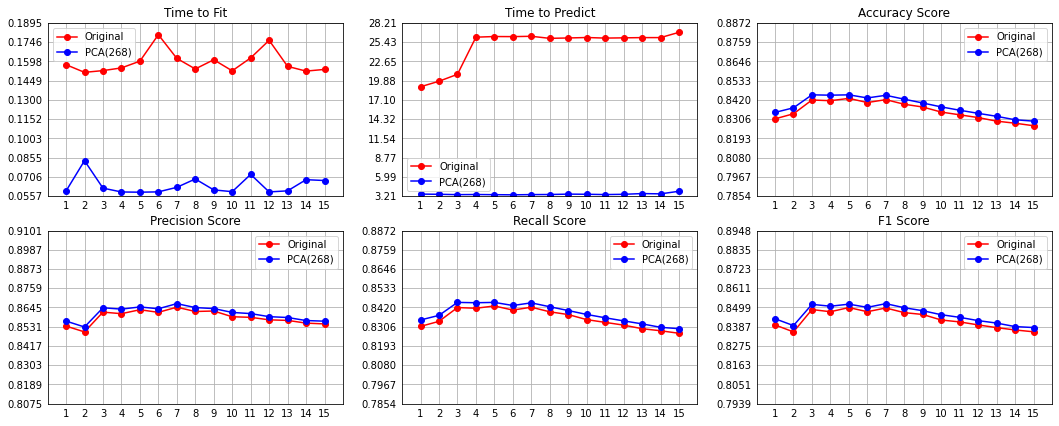

In [30]:
plot6Metrics(metricsKNN, metricsKNN_PCA, n_neighborsRange)

#### Вывод
Модель показывает хорошую точность при N=[3,8], дальнейшее увеличение N показывает отрицательную динамику<br>
Интересно заметить, что время предсказания после уменьшения размерности не изменяется при увеличении N<br>
PCA не влияет на точность предсказания

### LogisticRegression

In [31]:
from sklearn.linear_model import LogisticRegression

max_iterRangeLR = np.linspace(50, 500, 4, dtype=np.int32)

#### Базовая модель

In [32]:
metricsLR = MetricsPack()
metricsLR_PCA = MetricsPack()
for k in max_iterRangeLR:
    model = LogisticRegression(max_iter=k)
    scoreModel(model, metricsLR, bPCA=False)
    scoreModel(model, metricsLR_PCA, bPCA=True)

c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

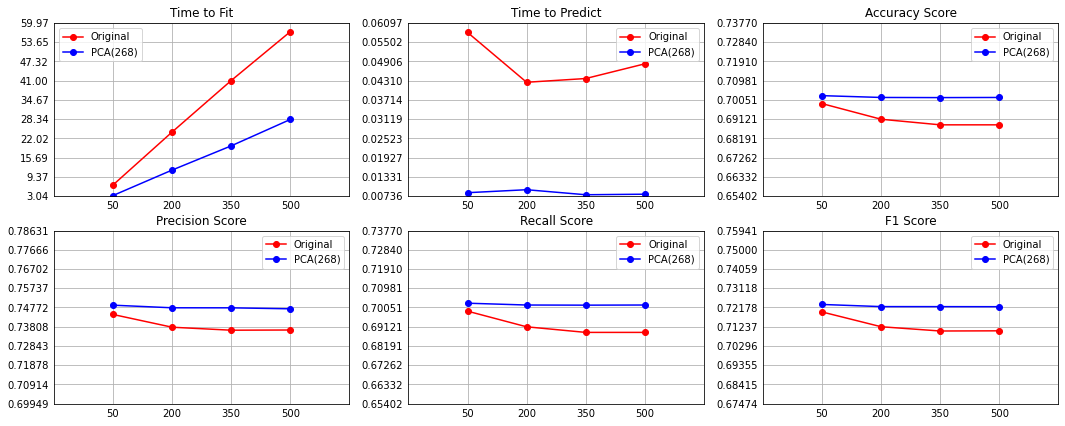

In [33]:
plot6Metrics(metricsLR, metricsLR_PCA, max_iterRangeLR)

Графики показывают уменьшение точности с ростом количества максимально допустимых шагов, но при работе модель генерирует предложения по улучшению:
Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

#### Модель со скалированием
Для упращения скалирования данных используется пайплайн, который дает интерфейс к составной моделе

In [34]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

metricsLR_scaled = MetricsPack()
metricsLR_PCA_scaled = MetricsPack()

for k in max_iterRangeLR:
    model = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(max_iter=k))
    scoreModel(model, metricsLR_scaled, bPCA=False)
    scoreModel(model, metricsLR_PCA_scaled, bPCA=True)


c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

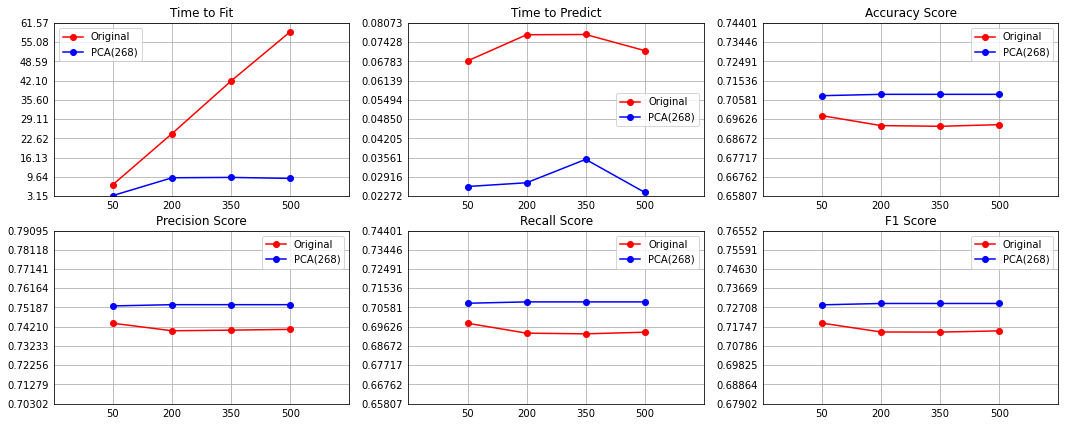

In [44]:
plot6Metrics(metricsLR_scaled, metricsLR_PCA_scaled, max_iterRangeLR)

#### Альтернативный солвер lbfgs

In [36]:
metricsLR_lbfgs = MetricsPack()
metricsLR_PCA_lbfgs = MetricsPack()
for k in max_iterRangeLR:
    model = LogisticRegression(max_iter=k, solver='saga')
    scoreModel(model, metricsLR_lbfgs, bPCA=False)
    scoreModel(model, metricsLR_PCA_lbfgs, bPCA=True)

c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


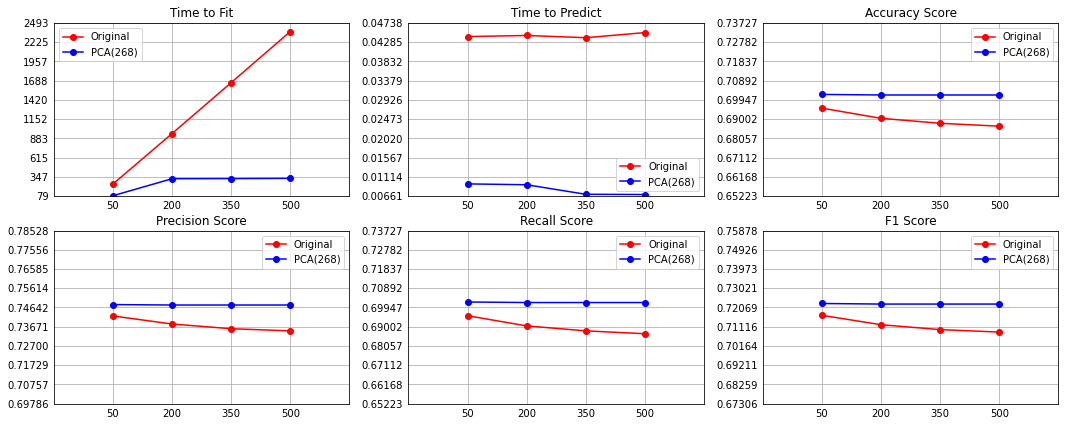

In [45]:
plot6Metrics(metricsLR_lbfgs, metricsLR_PCA_lbfgs, max_iterRangeLR)

#### Вывод
В среднем точность хуже на 15% чем у KNN.<br> Модель выдает большое количество предупреждений о нехватке итераций и предлагает скалировать данные/сменить солвер.<br>
Увеличение количества итераций не дает положительной динамики в метриках, при этом значительно увеличивает время обучения<br>
Скалирование данных не дало улучшения в точности<br>
Смена солвера приводит к ещё более значительному увлению времени обучения и не увеличивает точность<br>
PCA не влияет на точность предсказания

### Bayesian Classifier (Naive Bayes)

In [46]:
from sklearn.naive_bayes import MultinomialNB

smoothing = np.linspace(0.1, 1, 10)

##### после преобразований PCA появляются отрицательные значения <br>
Если я правильно понял, то MinMaxScaler берет минимальное значение и прибавляет его ко всем, а затем берет максимальное значение и делит на него все значения, что решает проблему наличия отрицаотельных чисел

In [60]:
from sklearn.preprocessing import MinMaxScaler

metricsBC = MetricsPack()
metricsBC_PCA = MetricsPack()
for k in smoothing:
    scoreModel(MultinomialNB(alpha=k), metricsBC, bPCA=False)
    scoreModel(make_pipeline(MinMaxScaler(), MultinomialNB(alpha=k)), metricsBC_PCA, bPCA=True)

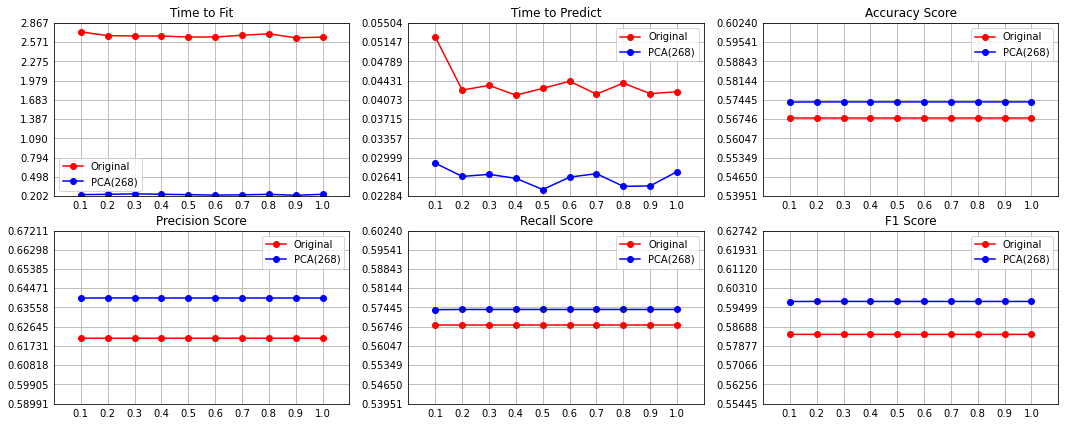

In [61]:
plot6Metrics(metricsBC, metricsBC_PCA, ((smoothing*10).round()/10))

#### Вывод
Низкая точность, скорее всего модель не подходит под данные или требуются какие-то преобразования
PCA не влияет на точность предсказания

### Linear SVC

In [62]:
from sklearn.svm import LinearSVC

max_iterRangeSVC = np.linspace(500, 2500, 4, dtype=np.int32)

In [63]:
metricsSVC = MetricsPack()
metricsSVC_PCA = MetricsPack()
for k in max_iterRangeSVC:
    model = LinearSVC(max_iter=k)
    scoreModel(model, metricsSVC, bPCA=False)
    scoreModel(model, metricsSVC_PCA, bPCA=True)

c:\Users\leysh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number 

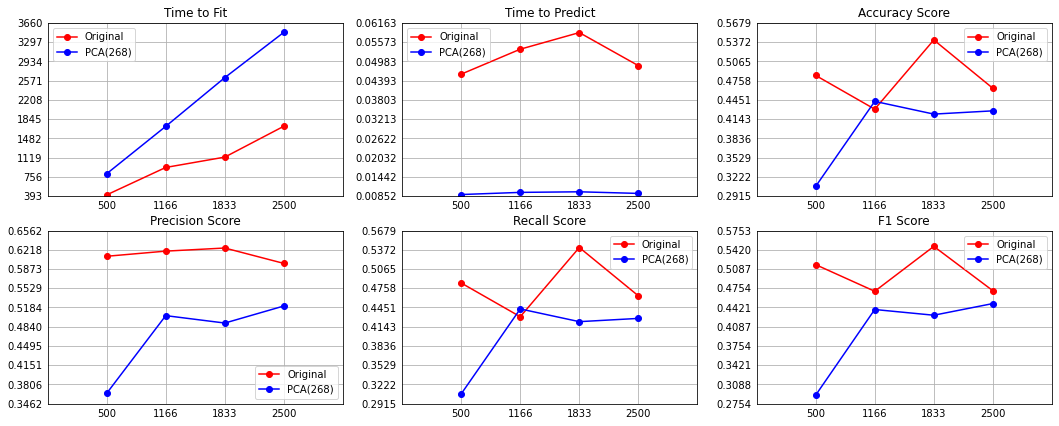

In [64]:
plot6Metrics(metricsSVC, metricsSVC_PCA, max_iterRangeSVC)

#### Вывод
Низкая точность, скорее всего модель не подходит под данные или требуются какие-то преобразования<br>
PCA значительно влияет на точность предсказания

### DecisionTreeClassifier

In [65]:
from sklearn.tree import DecisionTreeClassifier

max_depthDTC = np.linspace(3, 50, 12, dtype=np.int32)

In [66]:
metricsDTC = MetricsPack()
metricsDTC_PCA = MetricsPack()
for k in max_depthDTC:
    model = DecisionTreeClassifier(max_depth=k)
    scoreModel(model, metricsDTC, bPCA=False)
    scoreModel(model, metricsDTC_PCA, bPCA=True)

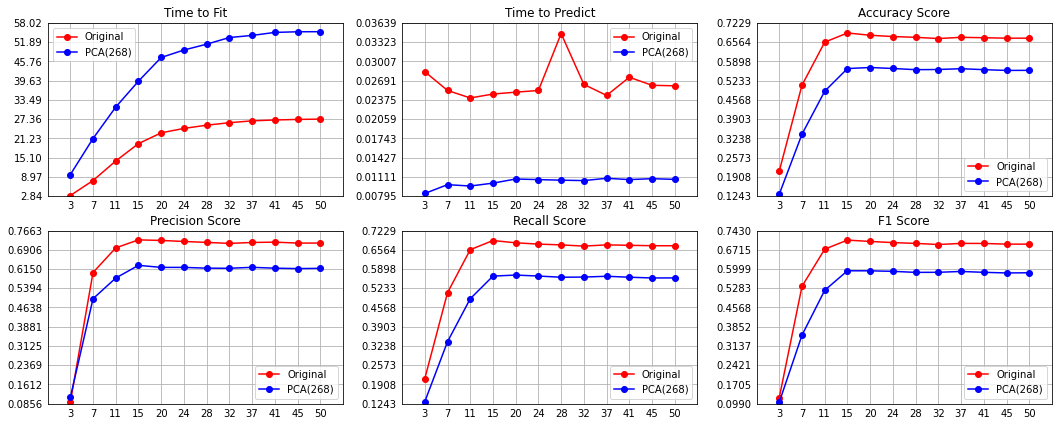

In [67]:
plot6Metrics(metricsDTC, metricsDTC_PCA, max_depthDTC)

#### Вывод
Низкая точность, скорее всего модель не подходит под данные или требуются какие-то преобразования<br>
PCA не влияет на точность предсказания

### RandomForestClassifier

In [68]:
from sklearn.ensemble import RandomForestClassifier

max_estimatorsRFC = np.linspace(50, 500, 12, dtype=np.int32)

In [69]:
metricsRFC = MetricsPack()
metricsRFC_PCA = MetricsPack()
for k in max_estimatorsRFC:
    model = RandomForestClassifier(n_estimators=k)
    scoreModel(model, metricsRFC, bPCA=False)
    scoreModel(model, metricsRFC_PCA, bPCA=True)

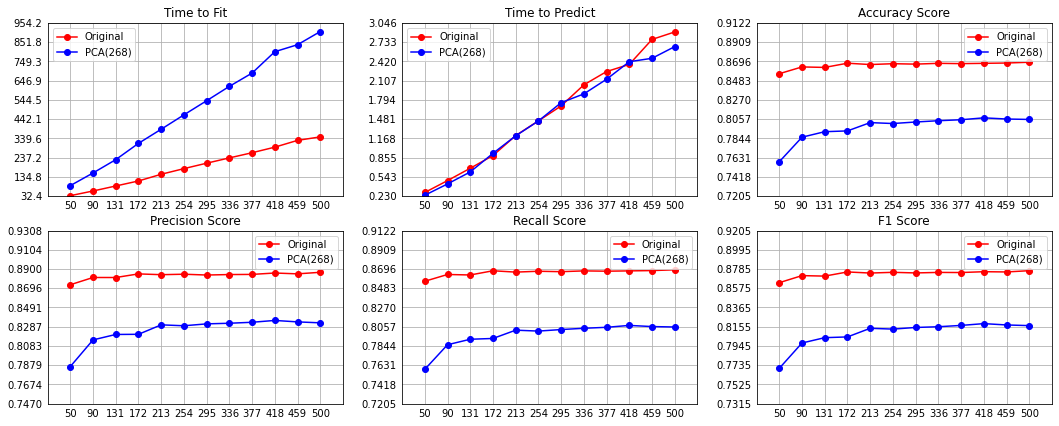

In [70]:
plot6Metrics(metricsRFC, metricsRFC_PCA, max_estimatorsRFC)

#### Вывод
Точность на уровне KNN, но время обучения значительно дольше чем у KNN<br>
При увеличении деревьев в лесу точность незначительно повышается, но при этом крато увеличивается время обучения<br>
PCA слабо влияет на точность предсказания

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 6)
PlotTrainingCurve(classifier, X_train, y_train, X_test, y_test)

## Попробуем улучшить результаты двух лучших моделей

### KNeighborsClassifier
Зафиксируем n_neighbors = 5, как оптимальное и будем варьировать доступные алгоритмы и функцию оценки весов

In [71]:
knn_alg =  {'auto', 'ball_tree', 'kd_tree', 'brute'}

In [72]:
metricsKNN_algs = MetricsPack()
metricsKNN_algs_PCA = MetricsPack()
for k in knn_alg:
    model = KNeighborsClassifier(n_neighbors = 5, algorithm=k)
    scoreModel(model, metricsKNN_algs, bPCA=False)
    print("Original model; step='", k, "' done")
    scoreModel(model, metricsKNN_algs_PCA, bPCA=True)
    print("PCA model; step='", k, "' done")

Original model; step=' brute ' done
PCA model; step=' brute ' done
Original model; step=' kd_tree ' done
PCA model; step=' kd_tree ' done
Original model; step=' ball_tree ' done
PCA model; step=' ball_tree ' done
Original model; step=' auto ' done
PCA model; step=' auto ' done


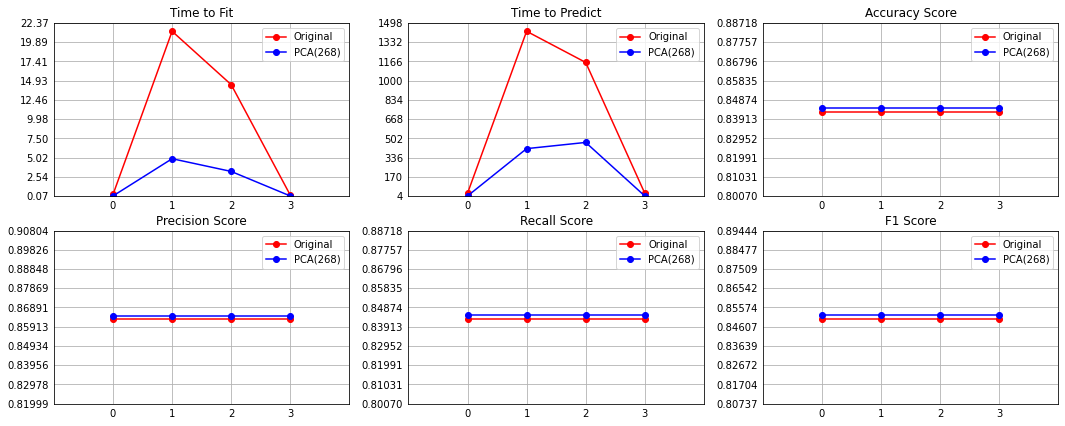

In [73]:
plot6Metrics(metricsKNN_algs, metricsKNN_algs_PCA, [])

In [74]:
knn_weights =  {'uniform', 'distance'}

In [75]:
metricsKNN_weights = MetricsPack()
metricsKNN_weights_PCA = MetricsPack()
for k in knn_weights:
    model = KNeighborsClassifier(n_neighbors = 5, weights=k)
    scoreModel(model, metricsKNN_weights, bPCA=False)
    scoreModel(model, metricsKNN_weights_PCA, bPCA=True)

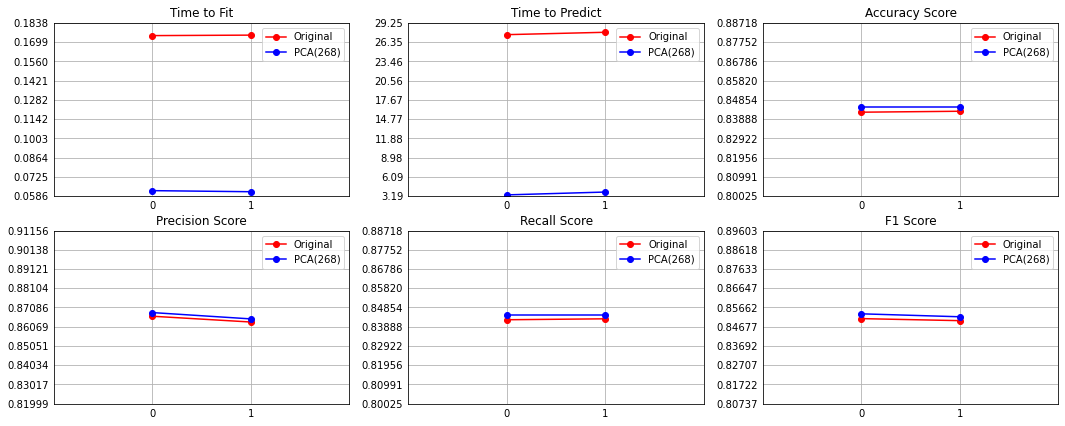

In [76]:
plot6Metrics(metricsKNN_weights, metricsKNN_weights_PCA, [])

### RandomForestClassifier

In [77]:
rfc_criterion = {"gini", "entropy", "log_loss"}

In [78]:
metricsRFC_criterion = MetricsPack()
metricsRFC_criterion_PCA = MetricsPack()
for k in rfc_criterion:
    model = RandomForestClassifier(n_estimators=213, criterion=k)
    scoreModel(model, metricsRFC_criterion, bPCA=False)
    scoreModel(model, metricsRFC_criterion_PCA, bPCA=True)

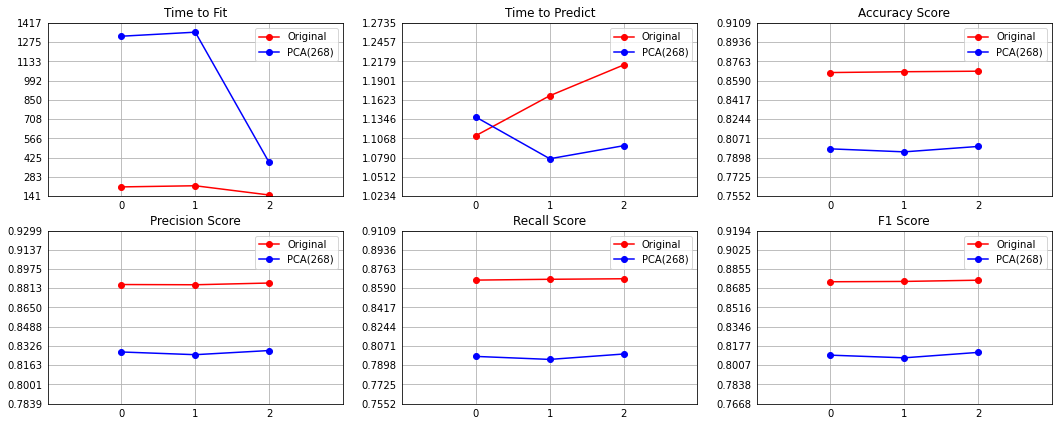

In [79]:
plot6Metrics(metricsRFC_criterion, metricsRFC_criterion_PCA, [])

In [80]:
max_features = {"sqrt", "log2", None}

In [81]:
metricsRFC_features = MetricsPack()
metricsRFC_features_PCA = MetricsPack()
for k in max_features:
    model = RandomForestClassifier(n_estimators=213, max_features=k)
    scoreModel(model, metricsRFC_features, bPCA=False)
    scoreModel(model, metricsRFC_features_PCA, bPCA=True)

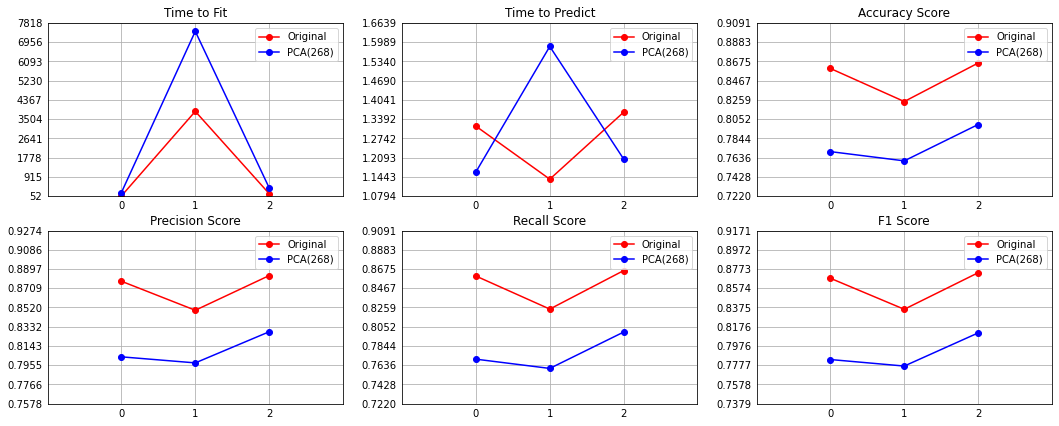

In [82]:
plot6Metrics(metricsRFC_features, metricsRFC_features_PCA, [])